In [1]:
!nvidia-smi

Mon Aug 15 06:03:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 29%   49C    P8    35W / 250W |    356MiB / 11016MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import json
import gc
import time
from tqdm import tqdm
import random
from collections import defaultdict
from IPython.display import display
from scipy.ndimage import binary_opening
from skimage.morphology import disk

#Pytorch Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler
# from tifffile import imread
import segmentation_models_pytorch as smp
# import transformers
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.model_selection import train_test_split

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings("ignore")

/home/lakshita/somusan/hubmap_kaggle/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hyperparameters etc.
# Hyperparameters
CONFIG = {
    "in_channels" :3,
    "num_classes": 1,
    "BATCH_SIZE" : 8,
    "NUM_EPOCHS" : 300,
    "n_accumulate": 1,
    "competition": "HuBMAP-Kaggle", # HuBMAP-Kaggle
    "model_name": "effnetb0_unet",
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", 
    "AUG": "No",
    "SEED": 888,
    "opt": 'Adam',
    "Normalization": "L2",
    "img_size": 512,
    "scheduler": 'CosineAnnealingLR',
    "warmup_epochs": 2,
    "n_folds": 5,
    "folds_to_run": [0],
    "min_lr": 1e-6,
    "T_max": 300, 
    "T_0": 20
}

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CONFIG["SEED"])

> SEEDING DONE


In [5]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/"
train_df = pd.read_csv(os.path.join(DIR,"train.csv"))
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [6]:
TRAIN_DIR = DIR + "train_images/"
func = lambda x: TRAIN_DIR + str(x) + ".tiff"
train_df["img_path"] = train_df["id"].apply(func)
# train_df.head()

In [7]:
MASK_DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/"
func1 = lambda x: MASK_DIR + str(x) + ".png"
train_df["mask_path"] = train_df["id"].apply(func1)
print(train_df["mask_path"].iloc[9])
train_df.head()

/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/10892.png


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,img_path,mask_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...,/home/lakshita/somusan/hubmap_kaggle/hubmap_da...


In [8]:
train_df["img_path"].iloc[0], train_df["mask_path"].iloc[0],

('/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff',
 '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/10044.png')

In [9]:
img = cv2.cvtColor(cv2.imread(train_df["img_path"].iloc[0]), cv2.COLOR_BGR2RGB)
mask = cv2.imread(train_df["mask_path"].iloc[0],cv2.IMREAD_GRAYSCALE)
img.shape

(3000, 3000, 3)

In [10]:
train_df, test_df = train_test_split(train_df, test_size=0.15, random_state=CONFIG["SEED"])
train_df.__len__(), len(test_df)

(298, 53)

In [11]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])


def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))



class hubmap_data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img_paths = df["img_path"].to_numpy()
        self.mask_paths = df["mask_path"].to_numpy()
        self.transform = transform
        
        
    def __getitem__(self, index):
        # load data from the pre-processed npy files
        img_file = self.img_paths[index]

        mask_file = self.mask_paths[index]
        
        # print(img_file)
        # print(mask_file)

        img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
        mask = cv2.imread((mask_file),cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
            mask=mask.reshape((1, mask.shape[0], mask.shape[1]))

            if mask.shape[-1] == 1:
                mask = mask.permute(2,0,1)
                

        return  img, mask 

    def __len__(self):
        return len(self.df)

In [12]:
train_transform = A.Compose([
        A.Resize(512, 512, p=1.0),
        
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=7),
            A.RandomBrightnessContrast(),
        ], p=0.35),
        ToTensorV2(),
    ], p=1.0)


test_transform = A.Compose(
    [
        A.Resize(512, 512, p=1.0),
        ToTensorV2(),
    ], p=1.0
)

In [13]:
train_data_ = hubmap_data(train_df, train_transform)
train_data_[0][1].dtype

torch.uint8

In [14]:
train_data = hubmap_data(train_df,train_transform)
test_data = hubmap_data(test_df, test_transform) # CHANGED [change the augmentation method]

print(train_data[10][0].shape, train_data[10][1].shape)
# test_data[10][0].shape, test_data[10][1].shape
print(train_data[10][1].dtype)

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.uint8


[0 1]


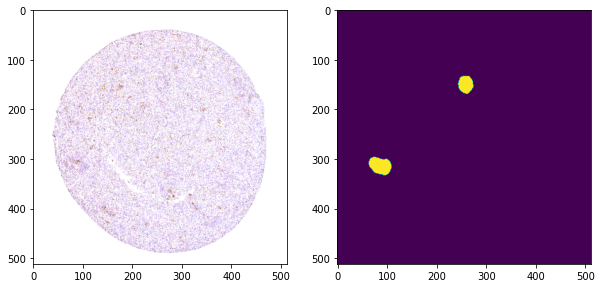

In [15]:
temp_img = train_data[51][0]
temp_mask = train_data[51][1]
# plt.imshow(temp_mask.detach().numpy())
# plt.imshow(temp_img.permute(1,2,0).detach().numpy())

img_trfm = (temp_img.permute(1,2,0)).detach().numpy()
mask_trfm = (temp_mask.permute(1,2,0)).detach().numpy()

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(img_trfm)


plt.subplot(1,2,2)
plt.imshow(mask_trfm.reshape(512,512))
print(np.unique(mask_trfm))
# temp_img.permute(1,2,0).detach().numpy() # 0.00784314 0.00392157

In [16]:
def init_model():
    model =  smp.Unet(
                 encoder_name='efficientnet-b0',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)
    return model

In [17]:
train_on_gpu = torch.cuda.is_available()
model = init_model() #UNet(n_channels=CONFIG["in_channels"], n_classes=CONFIG["num_classes"])
if train_on_gpu:
    model.cuda()

model(temp_img.unsqueeze(0).float().cuda()).shape

torch.Size([1, 1, 512, 512])

In [18]:
# REMARK shuffle = False [result might change with shuffle =True]
train_loader = torch.utils.data.DataLoader(
               dataset=train_data,
               batch_size=8,#CONFIG["BATCH_SIZE"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_data,
              batch_size=CONFIG["BATCH_SIZE"],
              shuffle=False,
              num_workers=2)

torch.uint8


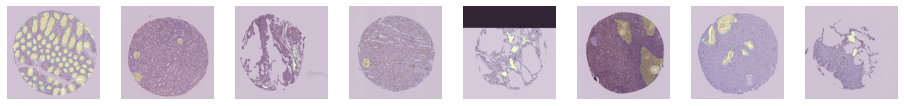

In [19]:
# ds = HuBMAPDataset(tfms=albu_aug())
# dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
it = iter(train_loader)
imgs,masks = next(it)
print(masks.dtype)
plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0))).numpy().astype(np.uint8)  # H , W , C
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
# del ds,dl,imgs,masks

In [20]:
def get_scheduler(optimizer):
    num_steps = 12
      
    if CONFIG["scheduler"] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
        
    elif CONFIG["scheduler"] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, threshold=0.0001, min_lr=1e-6)
    elif CONFIG["scheduler"] == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
        
    return scheduler

In [21]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
        self.diceloss = smp.losses.DiceLoss(mode='binary')
        self.binloss = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)

    def forward(self, outputs, mask):
        dice = self.diceloss(outputs,mask)
        bce = self.binloss(outputs , mask)
        loss = dice * 0.3 + bce * 0.7
        return loss

#DiceLoss() #Dice()
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
Dice_loss    = smp.losses.DiceLoss(mode='binary')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

loss_fn = CustomLoss() #BCELoss #Dice_loss
optimizer = optim.Adam(model.parameters(), lr=CONFIG["LEARNING_RATE"])

In [22]:
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        #Round off y_pred
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        dice = (2.0*intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    
    
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

dice_coe = DiceCoef()

In [23]:
model_path = "./model_weights_effunetb0_no_sch_orgsize_bin_class/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
def save_model(model, optimizer, criterion, epoch):
    """
    Function to save the trained model to disk.
    """
    print(f"\n Saving model at {epoch}th epoch")
    fname = f'{model_path}/{CONFIG["model_name"]}-{CONFIG["LEARNING_RATE"]}-{CONFIG["AUG"]}-{epoch}-{CONFIG["BATCH_SIZE"]}.pth'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, fname )
    return fname

In [24]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter#Training-Function
def train_fn(loader, model, optimizer, loss_fn,epoch, scheduler=None):
    bar = tqdm(enumerate(loader), total=len(loader))
    
    
    running_loss = 0.0
    dataset_size = 0
    
    for batch_idx, (data, targets) in bar:
        data = data.float().to(device=CONFIG["DEVICE"])
        targets = targets.float().to(device=CONFIG["DEVICE"])

        # forward
        predictions = model(data)

        loss = loss_fn(predictions, targets)

        
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update Weights
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
        # Calculate Loss
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(loader)
#         running_loss += (loss.item() * BATCH_SIZE)
#         dataset_size += BATCH_SIZE
        
#         epoch_loss = running_loss / dataset_size
        # update tqdm loop
        bar.set_postfix(Epoch=epoch,loss=epoch_loss)
    
        
    gc.collect()
    
    return epoch_loss

In [25]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, loss_fn):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
#     criterion = losses[CFG.loss]
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, masks) in pbar:
        images  = images.to(CONFIG["DEVICE"], dtype=torch.float)
        masks   = masks.to(CONFIG["DEVICE"], dtype=torch.float)
        
        
        y_pred  = model(images)
        loss    = loss_fn(y_pred, masks)
        
        running_loss += (loss.item() * CONFIG["BATCH_SIZE"])
        dataset_size += CONFIG["BATCH_SIZE"]
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        # msks = (y_pred.permute((0,2,3,1))>0.5).to(torch.uint8).cpu().detach().numpy()
        # seg = (msks >= 1).astype(np.uint8)  # binary mask
        # y_pred = binary_opening(seg, structure=disk(6)).astype(np.uint8)
        # y_pred = torch.from_numpy(y_pred)

        val_dice = dice_coef(masks, y_pred).cpu().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [26]:
history = defaultdict(list)
best_val_dice = -float('inf')
best_val_jaccard = -float('inf')
start = time.time()

# loss_fn = BCELoss
scheduler = get_scheduler(optimizer)

for epoch in range(CONFIG["NUM_EPOCHS"]):
    
    print(f'{sr_}===================== Epoch: [{epoch+1}/{CONFIG["NUM_EPOCHS"]}] =====================')

    # train and validation loop
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch+1, scheduler)
    val_loss, val_scores = valid_one_epoch(model, test_loader,CONFIG["DEVICE"], epoch+1, loss_fn)
    val_dice, val_jaccard = val_scores
    
    
    # save model
    model_file = save_model(model, optimizer, BCELoss, epoch+1)
    
    
    # weight and baise Log the metrics
    # wandb.log({"Train Loss": train_loss})
    # wandb.log({"Valid Loss": val_loss})
    # wandb.log({"Valid dice": val_dice})
    # wandb.log({"Valid jaccard": val_jaccard})

    # logging
    history["epoch"].append(epoch+1)
    history['Train_Loss'].append(train_loss)
    history['Valid_Loss'].append(val_loss)
    history['Valid_jaccard'].append(val_jaccard)
    history['Valid_dice'].append(val_dice)
    history["model_file"].append(model_file)

    
    # print loss and scores
    print(f"\n Final Train Loss: {train_loss:0.4f}  |  Final Val Loss: {val_loss:0.4f}") 
    
    print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    
    # print best val score
    if best_val_dice < val_dice:
        print(f"{b_}val dice increased: {best_val_dice} ---> {val_dice}")
        best_val_dice = val_dice
    
    if best_val_jaccard < val_jaccard:
        print(f"{b_}val jaccard increased: {best_val_jaccard} ---> {val_jaccard}")
        best_val_jaccard = val_jaccard
        
        
        
# print time
end = time.time()
time_elapsed = end - start
avg_time_per_epoch = time_elapsed/CONFIG["NUM_EPOCHS"] 
summary_df = pd.DataFrame.from_dict(history)

print(f'\n ====================== [Training Summary] ====================== \n')
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

print('avg time per [train + val] epoch {:.0f}h {:.0f}m {:.0f}s'.format(
    avg_time_per_epoch // 3600, (avg_time_per_epoch % 3600) // 60, (avg_time_per_epoch % 3600) % 60))

print("Best: ~~~~~~ dice: {:.4f}  || jaccard {:.4f} || val_loss {:.4f} || train_loss {:.4f} ~~~~~~".format(
    best_val_dice, best_val_jaccard, min(history['Valid_Loss']), min(history['Train_Loss'])))


summary_df.to_csv(model_path + 'training_summary.csv')
print("Saved training summary...")

print(f'\n =============================================================== \n')

display(summary_df)

plt.style.use('fivethirtyeight')
# plotting training and validation loss
plt.figure(figsize=(15,8))

fig1 = plt.subplot(2,2,1)
fig1.plot(history['epoch'], history['Train_Loss'], color='lime', marker='>')
fig1.set_title("train loss [dice]")
fig1.set(xlabel='epoch', ylabel='train loss')

fig2 = plt.subplot(2,2,2)
fig2.plot(history['epoch'], history['Valid_Loss'], color='cyan',  marker='>')
fig2.set_title("val loss [dice]")
fig2.set(xlabel='epoch', ylabel='val loss')

fig3 = plt.subplot(2,2,3)
fig3.plot(history['epoch'], history['Valid_dice'], color='orange',  marker='>')
fig3.set_title("Val Dice")
fig3.set(xlabel='epoch', ylabel='val dice')

fig4 = plt.subplot(2,2,4)
fig4.plot(history['epoch'], history['Valid_jaccard'], color='lightcoral',  marker='>')
fig4.set_title("val jaccard")
fig4.set(xlabel='epoch', ylabel='val jaccard')

plt.show();

===================== Epoch: [1/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.20it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=32.0516]



 Saving model at 1th epoch

 Final Train Loss: 0.7813  |  Final Val Loss: 32.0516
Valid Dice: 0.1372 | Valid Jaccard: 0.0771
val dice increased: -inf ---> 0.13723380863666534
val jaccard increased: -inf ---> 0.07712186127901077
===================== Epoch: [2/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.7765]



 Saving model at 2th epoch

 Final Train Loss: 3.5483  |  Final Val Loss: 0.7765
Valid Dice: 0.1374 | Valid Jaccard: 0.0756
val dice increased: 0.13723380863666534 ---> 0.13736365735530853
===================== Epoch: [3/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.6871]



 Saving model at 3th epoch

 Final Train Loss: 0.7467  |  Final Val Loss: 0.6871
Valid Dice: 0.1588 | Valid Jaccard: 0.0890
val dice increased: 0.13736365735530853 ---> 0.15877434611320496
val jaccard increased: 0.07712186127901077 ---> 0.0890023484826088
===================== Epoch: [4/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.6561]



 Saving model at 4th epoch

 Final Train Loss: 0.6887  |  Final Val Loss: 0.6561
Valid Dice: 0.1623 | Valid Jaccard: 0.0913
val dice increased: 0.15877434611320496 ---> 0.16232050955295563
val jaccard increased: 0.0890023484826088 ---> 0.09129811078310013
===================== Epoch: [5/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.6383]



 Saving model at 5th epoch

 Final Train Loss: 0.6581  |  Final Val Loss: 0.6383
Valid Dice: 0.1647 | Valid Jaccard: 0.0927
val dice increased: 0.16232050955295563 ---> 0.16468143463134766
val jaccard increased: 0.09129811078310013 ---> 0.09274496138095856
===================== Epoch: [6/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.6307]



 Saving model at 6th epoch

 Final Train Loss: 0.6459  |  Final Val Loss: 0.6307
Valid Dice: 0.1710 | Valid Jaccard: 0.0969
val dice increased: 0.16468143463134766 ---> 0.17103907465934753
val jaccard increased: 0.09274496138095856 ---> 0.09686005115509033
===================== Epoch: [7/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.6261]



 Saving model at 7th epoch

 Final Train Loss: 0.6381  |  Final Val Loss: 0.6261
Valid Dice: 0.1719 | Valid Jaccard: 0.0975
val dice increased: 0.17103907465934753 ---> 0.17194664478302002
val jaccard increased: 0.09686005115509033 ---> 0.0974796861410141
===================== Epoch: [8/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.6239]



 Saving model at 8th epoch

 Final Train Loss: 0.6344  |  Final Val Loss: 0.6239
Valid Dice: 0.1682 | Valid Jaccard: 0.0950
===================== Epoch: [9/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.6231]



 Saving model at 9th epoch

 Final Train Loss: 0.6328  |  Final Val Loss: 0.6231
Valid Dice: 0.1684 | Valid Jaccard: 0.0952
===================== Epoch: [10/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.6173]



 Saving model at 10th epoch

 Final Train Loss: 0.6291  |  Final Val Loss: 0.6173
Valid Dice: 0.1642 | Valid Jaccard: 0.0925
===================== Epoch: [11/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.6294]



 Saving model at 11th epoch

 Final Train Loss: 0.6301  |  Final Val Loss: 0.6294
Valid Dice: 0.1338 | Valid Jaccard: 0.0736
===================== Epoch: [12/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.6003]



 Saving model at 12th epoch

 Final Train Loss: 0.6241  |  Final Val Loss: 0.6003
Valid Dice: 0.1531 | Valid Jaccard: 0.0853
===================== Epoch: [13/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.5920]



 Saving model at 13th epoch

 Final Train Loss: 0.6003  |  Final Val Loss: 0.5920
Valid Dice: 0.1164 | Valid Jaccard: 0.0635
===================== Epoch: [14/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5735]



 Saving model at 14th epoch

 Final Train Loss: 0.5870  |  Final Val Loss: 0.5735
Valid Dice: 0.0826 | Valid Jaccard: 0.0443
===================== Epoch: [15/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5708]



 Saving model at 15th epoch

 Final Train Loss: 0.5742  |  Final Val Loss: 0.5708
Valid Dice: 0.0674 | Valid Jaccard: 0.0359
===================== Epoch: [16/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5771]



 Saving model at 16th epoch

 Final Train Loss: 0.5599  |  Final Val Loss: 0.5771
Valid Dice: 0.0741 | Valid Jaccard: 0.0415
===================== Epoch: [17/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5704]



 Saving model at 17th epoch

 Final Train Loss: 0.5592  |  Final Val Loss: 0.5704
Valid Dice: 0.0585 | Valid Jaccard: 0.0316
===================== Epoch: [18/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.5569]



 Saving model at 18th epoch

 Final Train Loss: 0.5599  |  Final Val Loss: 0.5569
Valid Dice: 0.0877 | Valid Jaccard: 0.0495
===================== Epoch: [19/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.5503]



 Saving model at 19th epoch

 Final Train Loss: 0.5514  |  Final Val Loss: 0.5503
Valid Dice: 0.1151 | Valid Jaccard: 0.0665
===================== Epoch: [20/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.5473]



 Saving model at 20th epoch

 Final Train Loss: 0.5444  |  Final Val Loss: 0.5473
Valid Dice: 0.1963 | Valid Jaccard: 0.1250
val dice increased: 0.17194664478302002 ---> 0.19627918303012848
val jaccard increased: 0.0974796861410141 ---> 0.12496088445186615
===================== Epoch: [21/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.5430]



 Saving model at 21th epoch

 Final Train Loss: 0.5315  |  Final Val Loss: 0.5430
Valid Dice: 0.1770 | Valid Jaccard: 0.1147
===================== Epoch: [22/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.5397]



 Saving model at 22th epoch

 Final Train Loss: 0.5297  |  Final Val Loss: 0.5397
Valid Dice: 0.2059 | Valid Jaccard: 0.1376
val dice increased: 0.19627918303012848 ---> 0.20594000816345215
val jaccard increased: 0.12496088445186615 ---> 0.13759435713291168
===================== Epoch: [23/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.5389]



 Saving model at 23th epoch

 Final Train Loss: 0.5288  |  Final Val Loss: 0.5389
Valid Dice: 0.2195 | Valid Jaccard: 0.1475
val dice increased: 0.20594000816345215 ---> 0.21951492130756378
val jaccard increased: 0.13759435713291168 ---> 0.14745596051216125
===================== Epoch: [24/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.5393]



 Saving model at 24th epoch

 Final Train Loss: 0.5194  |  Final Val Loss: 0.5393
Valid Dice: 0.2249 | Valid Jaccard: 0.1515
val dice increased: 0.21951492130756378 ---> 0.22493641078472137
val jaccard increased: 0.14745596051216125 ---> 0.15147008001804352
===================== Epoch: [25/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.5413]



 Saving model at 25th epoch

 Final Train Loss: 0.5212  |  Final Val Loss: 0.5413
Valid Dice: 0.2332 | Valid Jaccard: 0.1577
val dice increased: 0.22493641078472137 ---> 0.23320987820625305
val jaccard increased: 0.15147008001804352 ---> 0.15772175788879395
===================== Epoch: [26/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.5537]



 Saving model at 26th epoch

 Final Train Loss: 0.5277  |  Final Val Loss: 0.5537
Valid Dice: 0.1271 | Valid Jaccard: 0.0773
===================== Epoch: [27/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.5454]



 Saving model at 27th epoch

 Final Train Loss: 0.5483  |  Final Val Loss: 0.5454
Valid Dice: 0.1623 | Valid Jaccard: 0.1008
===================== Epoch: [28/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.5419]



 Saving model at 28th epoch

 Final Train Loss: 0.5340  |  Final Val Loss: 0.5419
Valid Dice: 0.1789 | Valid Jaccard: 0.1165
===================== Epoch: [29/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.5373]



 Saving model at 29th epoch

 Final Train Loss: 0.5279  |  Final Val Loss: 0.5373
Valid Dice: 0.2095 | Valid Jaccard: 0.1390
===================== Epoch: [30/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5392]



 Saving model at 30th epoch

 Final Train Loss: 0.5392  |  Final Val Loss: 0.5392
Valid Dice: 0.1922 | Valid Jaccard: 0.1244
===================== Epoch: [31/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5350]



 Saving model at 31th epoch

 Final Train Loss: 0.5298  |  Final Val Loss: 0.5350
Valid Dice: 0.2412 | Valid Jaccard: 0.1647
val dice increased: 0.23320987820625305 ---> 0.2412133663892746
val jaccard increased: 0.15772175788879395 ---> 0.16470374166965485
===================== Epoch: [32/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5349]



 Saving model at 32th epoch

 Final Train Loss: 0.5282  |  Final Val Loss: 0.5349
Valid Dice: 0.2058 | Valid Jaccard: 0.1381
===================== Epoch: [33/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5401]



 Saving model at 33th epoch

 Final Train Loss: 0.5220  |  Final Val Loss: 0.5401
Valid Dice: 0.1861 | Valid Jaccard: 0.1232
===================== Epoch: [34/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.5317]



 Saving model at 34th epoch

 Final Train Loss: 0.5080  |  Final Val Loss: 0.5317
Valid Dice: 0.2029 | Valid Jaccard: 0.1392
===================== Epoch: [35/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.5291]



 Saving model at 35th epoch

 Final Train Loss: 0.5116  |  Final Val Loss: 0.5291
Valid Dice: 0.2453 | Valid Jaccard: 0.1707
val dice increased: 0.2412133663892746 ---> 0.24530191719532013
val jaccard increased: 0.16470374166965485 ---> 0.1706530600786209
===================== Epoch: [36/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.5324]



 Saving model at 36th epoch

 Final Train Loss: 0.5139  |  Final Val Loss: 0.5324
Valid Dice: 0.1919 | Valid Jaccard: 0.1279
===================== Epoch: [37/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.5254]



 Saving model at 37th epoch

 Final Train Loss: 0.5026  |  Final Val Loss: 0.5254
Valid Dice: 0.2324 | Valid Jaccard: 0.1641
===================== Epoch: [38/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.5288]



 Saving model at 38th epoch

 Final Train Loss: 0.5038  |  Final Val Loss: 0.5288
Valid Dice: 0.2477 | Valid Jaccard: 0.1739
val dice increased: 0.24530191719532013 ---> 0.24770846962928772
val jaccard increased: 0.1706530600786209 ---> 0.17390967905521393
===================== Epoch: [39/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.5266]



 Saving model at 39th epoch

 Final Train Loss: 0.4987  |  Final Val Loss: 0.5266
Valid Dice: 0.2341 | Valid Jaccard: 0.1652
===================== Epoch: [40/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.5266]



 Saving model at 40th epoch

 Final Train Loss: 0.4949  |  Final Val Loss: 0.5266
Valid Dice: 0.2347 | Valid Jaccard: 0.1656
===================== Epoch: [41/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.5270]



 Saving model at 41th epoch

 Final Train Loss: 0.4998  |  Final Val Loss: 0.5270
Valid Dice: 0.2370 | Valid Jaccard: 0.1672
===================== Epoch: [42/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.5255]



 Saving model at 42th epoch

 Final Train Loss: 0.5033  |  Final Val Loss: 0.5255
Valid Dice: 0.2351 | Valid Jaccard: 0.1660
===================== Epoch: [43/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.5272]



 Saving model at 43th epoch

 Final Train Loss: 0.4977  |  Final Val Loss: 0.5272
Valid Dice: 0.2247 | Valid Jaccard: 0.1593
===================== Epoch: [44/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.61it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.5309]



 Saving model at 44th epoch

 Final Train Loss: 0.4959  |  Final Val Loss: 0.5309
Valid Dice: 0.2131 | Valid Jaccard: 0.1509
===================== Epoch: [45/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.5364]



 Saving model at 45th epoch

 Final Train Loss: 0.4970  |  Final Val Loss: 0.5364
Valid Dice: 0.1834 | Valid Jaccard: 0.1302
===================== Epoch: [46/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5213]



 Saving model at 46th epoch

 Final Train Loss: 0.5042  |  Final Val Loss: 0.5213
Valid Dice: 0.2618 | Valid Jaccard: 0.1858
val dice increased: 0.24770846962928772 ---> 0.2618454396724701
val jaccard increased: 0.17390967905521393 ---> 0.18582835793495178
===================== Epoch: [47/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5318]



 Saving model at 47th epoch

 Final Train Loss: 0.5018  |  Final Val Loss: 0.5318
Valid Dice: 0.1948 | Valid Jaccard: 0.1359
===================== Epoch: [48/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5403]



 Saving model at 48th epoch

 Final Train Loss: 0.5117  |  Final Val Loss: 0.5403
Valid Dice: 0.1809 | Valid Jaccard: 0.1228
===================== Epoch: [49/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5254]



 Saving model at 49th epoch

 Final Train Loss: 0.5087  |  Final Val Loss: 0.5254
Valid Dice: 0.2594 | Valid Jaccard: 0.1849
===================== Epoch: [50/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.5189]



 Saving model at 50th epoch

 Final Train Loss: 0.4954  |  Final Val Loss: 0.5189
Valid Dice: 0.2586 | Valid Jaccard: 0.1862
val jaccard increased: 0.18582835793495178 ---> 0.18623705208301544
===================== Epoch: [51/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.5218]



 Saving model at 51th epoch

 Final Train Loss: 0.4955  |  Final Val Loss: 0.5218
Valid Dice: 0.2327 | Valid Jaccard: 0.1660
===================== Epoch: [52/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.5222]



 Saving model at 52th epoch

 Final Train Loss: 0.4917  |  Final Val Loss: 0.5222
Valid Dice: 0.2486 | Valid Jaccard: 0.1794
===================== Epoch: [53/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.5203]



 Saving model at 53th epoch

 Final Train Loss: 0.4832  |  Final Val Loss: 0.5203
Valid Dice: 0.2686 | Valid Jaccard: 0.1938
val dice increased: 0.2618454396724701 ---> 0.2686093747615814
val jaccard increased: 0.18623705208301544 ---> 0.19378837943077087
===================== Epoch: [54/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.5171]



 Saving model at 54th epoch

 Final Train Loss: 0.4839  |  Final Val Loss: 0.5171
Valid Dice: 0.2628 | Valid Jaccard: 0.1895
===================== Epoch: [55/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.5169]



 Saving model at 55th epoch

 Final Train Loss: 0.4819  |  Final Val Loss: 0.5169
Valid Dice: 0.2590 | Valid Jaccard: 0.1871
===================== Epoch: [56/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.5167]



 Saving model at 56th epoch

 Final Train Loss: 0.4829  |  Final Val Loss: 0.5167
Valid Dice: 0.2608 | Valid Jaccard: 0.1884
===================== Epoch: [57/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.5173]



 Saving model at 57th epoch

 Final Train Loss: 0.4800  |  Final Val Loss: 0.5173
Valid Dice: 0.2619 | Valid Jaccard: 0.1891
===================== Epoch: [58/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.5168]



 Saving model at 58th epoch

 Final Train Loss: 0.4865  |  Final Val Loss: 0.5168
Valid Dice: 0.2540 | Valid Jaccard: 0.1828
===================== Epoch: [59/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.5172]



 Saving model at 59th epoch

 Final Train Loss: 0.4883  |  Final Val Loss: 0.5172
Valid Dice: 0.2525 | Valid Jaccard: 0.1817
===================== Epoch: [60/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5213]



 Saving model at 60th epoch

 Final Train Loss: 0.4871  |  Final Val Loss: 0.5213
Valid Dice: 0.2434 | Valid Jaccard: 0.1739
===================== Epoch: [61/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.5207]



 Saving model at 61th epoch

 Final Train Loss: 0.4912  |  Final Val Loss: 0.5207
Valid Dice: 0.2300 | Valid Jaccard: 0.1659
===================== Epoch: [62/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5345]



 Saving model at 62th epoch

 Final Train Loss: 0.4867  |  Final Val Loss: 0.5345
Valid Dice: 0.1852 | Valid Jaccard: 0.1285
===================== Epoch: [63/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5317]



 Saving model at 63th epoch

 Final Train Loss: 0.5035  |  Final Val Loss: 0.5317
Valid Dice: 0.2868 | Valid Jaccard: 0.2033
val dice increased: 0.2686093747615814 ---> 0.28678789734840393
val jaccard increased: 0.19378837943077087 ---> 0.20332089066505432
===================== Epoch: [64/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.87it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5229]



 Saving model at 64th epoch

 Final Train Loss: 0.4996  |  Final Val Loss: 0.5229
Valid Dice: 0.2853 | Valid Jaccard: 0.2055
val jaccard increased: 0.20332089066505432 ---> 0.20550556480884552
===================== Epoch: [65/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5212]



 Saving model at 65th epoch

 Final Train Loss: 0.4896  |  Final Val Loss: 0.5212
Valid Dice: 0.2925 | Valid Jaccard: 0.2103
val dice increased: 0.28678789734840393 ---> 0.2925082743167877
val jaccard increased: 0.20550556480884552 ---> 0.2103385031223297
===================== Epoch: [66/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5156]



 Saving model at 66th epoch

 Final Train Loss: 0.4947  |  Final Val Loss: 0.5156
Valid Dice: 0.2478 | Valid Jaccard: 0.1794
===================== Epoch: [67/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.5176]



 Saving model at 67th epoch

 Final Train Loss: 0.4862  |  Final Val Loss: 0.5176
Valid Dice: 0.2546 | Valid Jaccard: 0.1843
===================== Epoch: [68/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.5131]



 Saving model at 68th epoch

 Final Train Loss: 0.4817  |  Final Val Loss: 0.5131
Valid Dice: 0.2730 | Valid Jaccard: 0.2003
===================== Epoch: [69/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.5120]



 Saving model at 69th epoch

 Final Train Loss: 0.4769  |  Final Val Loss: 0.5120
Valid Dice: 0.2962 | Valid Jaccard: 0.2137
val dice increased: 0.2925082743167877 ---> 0.2961786687374115
val jaccard increased: 0.2103385031223297 ---> 0.213734969496727
===================== Epoch: [70/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.5088]



 Saving model at 70th epoch

 Final Train Loss: 0.4729  |  Final Val Loss: 0.5088
Valid Dice: 0.2767 | Valid Jaccard: 0.2021
===================== Epoch: [71/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.5087]



 Saving model at 71th epoch

 Final Train Loss: 0.4771  |  Final Val Loss: 0.5087
Valid Dice: 0.2801 | Valid Jaccard: 0.2046
===================== Epoch: [72/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.5089]



 Saving model at 72th epoch

 Final Train Loss: 0.4711  |  Final Val Loss: 0.5089
Valid Dice: 0.2771 | Valid Jaccard: 0.2027
===================== Epoch: [73/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.5115]



 Saving model at 73th epoch

 Final Train Loss: 0.4764  |  Final Val Loss: 0.5115
Valid Dice: 0.2871 | Valid Jaccard: 0.2085
===================== Epoch: [74/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.5111]



 Saving model at 74th epoch

 Final Train Loss: 0.4782  |  Final Val Loss: 0.5111
Valid Dice: 0.2909 | Valid Jaccard: 0.2111
===================== Epoch: [75/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.5233]



 Saving model at 75th epoch

 Final Train Loss: 0.4813  |  Final Val Loss: 0.5233
Valid Dice: 0.2247 | Valid Jaccard: 0.1597
===================== Epoch: [76/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5220]



 Saving model at 76th epoch

 Final Train Loss: 0.4843  |  Final Val Loss: 0.5220
Valid Dice: 0.2744 | Valid Jaccard: 0.1977
===================== Epoch: [77/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5135]



 Saving model at 77th epoch

 Final Train Loss: 0.4873  |  Final Val Loss: 0.5135
Valid Dice: 0.2699 | Valid Jaccard: 0.1946
===================== Epoch: [78/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5224]



 Saving model at 78th epoch

 Final Train Loss: 0.4859  |  Final Val Loss: 0.5224
Valid Dice: 0.2387 | Valid Jaccard: 0.1727
===================== Epoch: [79/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5208]



 Saving model at 79th epoch

 Final Train Loss: 0.4810  |  Final Val Loss: 0.5208
Valid Dice: 0.2320 | Valid Jaccard: 0.1714
===================== Epoch: [80/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5172]



 Saving model at 80th epoch

 Final Train Loss: 0.4997  |  Final Val Loss: 0.5172
Valid Dice: 0.2674 | Valid Jaccard: 0.1934
===================== Epoch: [81/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.5130]



 Saving model at 81th epoch

 Final Train Loss: 0.4826  |  Final Val Loss: 0.5130
Valid Dice: 0.2817 | Valid Jaccard: 0.2050
===================== Epoch: [82/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5109]



 Saving model at 82th epoch

 Final Train Loss: 0.4925  |  Final Val Loss: 0.5109
Valid Dice: 0.2747 | Valid Jaccard: 0.1996
===================== Epoch: [83/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.5087]



 Saving model at 83th epoch

 Final Train Loss: 0.4793  |  Final Val Loss: 0.5087
Valid Dice: 0.2756 | Valid Jaccard: 0.1969
===================== Epoch: [84/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.5057]



 Saving model at 84th epoch

 Final Train Loss: 0.4715  |  Final Val Loss: 0.5057
Valid Dice: 0.3106 | Valid Jaccard: 0.2249
val dice increased: 0.2961786687374115 ---> 0.3106078803539276
val jaccard increased: 0.213734969496727 ---> 0.2248680591583252
===================== Epoch: [85/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.5120]



 Saving model at 85th epoch

 Final Train Loss: 0.4722  |  Final Val Loss: 0.5120
Valid Dice: 0.3104 | Valid Jaccard: 0.2231
===================== Epoch: [86/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.5049]



 Saving model at 86th epoch

 Final Train Loss: 0.4732  |  Final Val Loss: 0.5049
Valid Dice: 0.2945 | Valid Jaccard: 0.2144
===================== Epoch: [87/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.5054]



 Saving model at 87th epoch

 Final Train Loss: 0.4704  |  Final Val Loss: 0.5054
Valid Dice: 0.2950 | Valid Jaccard: 0.2147
===================== Epoch: [88/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.5055]



 Saving model at 88th epoch

 Final Train Loss: 0.4673  |  Final Val Loss: 0.5055
Valid Dice: 0.2921 | Valid Jaccard: 0.2122
===================== Epoch: [89/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.5067]



 Saving model at 89th epoch

 Final Train Loss: 0.4656  |  Final Val Loss: 0.5067
Valid Dice: 0.3045 | Valid Jaccard: 0.2203
===================== Epoch: [90/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.5090]



 Saving model at 90th epoch

 Final Train Loss: 0.4678  |  Final Val Loss: 0.5090
Valid Dice: 0.3051 | Valid Jaccard: 0.2197
===================== Epoch: [91/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.5077]



 Saving model at 91th epoch

 Final Train Loss: 0.4654  |  Final Val Loss: 0.5077
Valid Dice: 0.2901 | Valid Jaccard: 0.2112
===================== Epoch: [92/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5105]



 Saving model at 92th epoch

 Final Train Loss: 0.4736  |  Final Val Loss: 0.5105
Valid Dice: 0.2820 | Valid Jaccard: 0.2055
===================== Epoch: [93/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5049]



 Saving model at 93th epoch

 Final Train Loss: 0.4750  |  Final Val Loss: 0.5049
Valid Dice: 0.3182 | Valid Jaccard: 0.2306
val dice increased: 0.3106078803539276 ---> 0.3182142674922943
val jaccard increased: 0.2248680591583252 ---> 0.23058687150478363
===================== Epoch: [94/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5086]



 Saving model at 94th epoch

 Final Train Loss: 0.4710  |  Final Val Loss: 0.5086
Valid Dice: 0.2756 | Valid Jaccard: 0.2024
===================== Epoch: [95/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5073]



 Saving model at 95th epoch

 Final Train Loss: 0.4692  |  Final Val Loss: 0.5073
Valid Dice: 0.3235 | Valid Jaccard: 0.2329
val dice increased: 0.3182142674922943 ---> 0.32347947359085083
val jaccard increased: 0.23058687150478363 ---> 0.23287512362003326
===================== Epoch: [96/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5147]



 Saving model at 96th epoch

 Final Train Loss: 0.4685  |  Final Val Loss: 0.5147
Valid Dice: 0.2843 | Valid Jaccard: 0.2099
===================== Epoch: [97/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4988]



 Saving model at 97th epoch

 Final Train Loss: 0.4708  |  Final Val Loss: 0.4988
Valid Dice: 0.3190 | Valid Jaccard: 0.2327
===================== Epoch: [98/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4983]



 Saving model at 98th epoch

 Final Train Loss: 0.4657  |  Final Val Loss: 0.4983
Valid Dice: 0.3173 | Valid Jaccard: 0.2277
===================== Epoch: [99/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.5027]



 Saving model at 99th epoch

 Final Train Loss: 0.4749  |  Final Val Loss: 0.5027
Valid Dice: 0.2962 | Valid Jaccard: 0.2147
===================== Epoch: [100/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4998]



 Saving model at 100th epoch

 Final Train Loss: 0.4672  |  Final Val Loss: 0.4998
Valid Dice: 0.3270 | Valid Jaccard: 0.2384
val dice increased: 0.32347947359085083 ---> 0.3269965946674347
val jaccard increased: 0.23287512362003326 ---> 0.23839016258716583
===================== Epoch: [101/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.91it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4990]



 Saving model at 101th epoch

 Final Train Loss: 0.4599  |  Final Val Loss: 0.4990
Valid Dice: 0.3301 | Valid Jaccard: 0.2402
val dice increased: 0.3269965946674347 ---> 0.33011648058891296
val jaccard increased: 0.23839016258716583 ---> 0.24023978412151337
===================== Epoch: [102/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4964]



 Saving model at 102th epoch

 Final Train Loss: 0.4520  |  Final Val Loss: 0.4964
Valid Dice: 0.3255 | Valid Jaccard: 0.2382
===================== Epoch: [103/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4960]



 Saving model at 103th epoch

 Final Train Loss: 0.4541  |  Final Val Loss: 0.4960
Valid Dice: 0.3270 | Valid Jaccard: 0.2393
===================== Epoch: [104/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4960]



 Saving model at 104th epoch

 Final Train Loss: 0.4558  |  Final Val Loss: 0.4960
Valid Dice: 0.3279 | Valid Jaccard: 0.2401
===================== Epoch: [105/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4950]



 Saving model at 105th epoch

 Final Train Loss: 0.4585  |  Final Val Loss: 0.4950
Valid Dice: 0.3316 | Valid Jaccard: 0.2423
val dice increased: 0.33011648058891296 ---> 0.33159175515174866
val jaccard increased: 0.24023978412151337 ---> 0.24226923286914825
===================== Epoch: [106/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4988]



 Saving model at 106th epoch

 Final Train Loss: 0.4556  |  Final Val Loss: 0.4988
Valid Dice: 0.3264 | Valid Jaccard: 0.2392
===================== Epoch: [107/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.5013]



 Saving model at 107th epoch

 Final Train Loss: 0.4663  |  Final Val Loss: 0.5013
Valid Dice: 0.3151 | Valid Jaccard: 0.2295
===================== Epoch: [108/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.5019]



 Saving model at 108th epoch

 Final Train Loss: 0.4619  |  Final Val Loss: 0.5019
Valid Dice: 0.3266 | Valid Jaccard: 0.2363
===================== Epoch: [109/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5131]



 Saving model at 109th epoch

 Final Train Loss: 0.4683  |  Final Val Loss: 0.5131
Valid Dice: 0.3628 | Valid Jaccard: 0.2643
val dice increased: 0.33159175515174866 ---> 0.36278122663497925
val jaccard increased: 0.24226923286914825 ---> 0.2642613649368286
===================== Epoch: [110/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5000]



 Saving model at 110th epoch

 Final Train Loss: 0.4742  |  Final Val Loss: 0.5000
Valid Dice: 0.2939 | Valid Jaccard: 0.2142
===================== Epoch: [111/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5038]



 Saving model at 111th epoch

 Final Train Loss: 0.4721  |  Final Val Loss: 0.5038
Valid Dice: 0.2940 | Valid Jaccard: 0.2130
===================== Epoch: [112/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5199]



 Saving model at 112th epoch

 Final Train Loss: 0.4615  |  Final Val Loss: 0.5199
Valid Dice: 0.2633 | Valid Jaccard: 0.1922
===================== Epoch: [113/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4999]



 Saving model at 113th epoch

 Final Train Loss: 0.4597  |  Final Val Loss: 0.4999
Valid Dice: 0.3218 | Valid Jaccard: 0.2336
===================== Epoch: [114/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.5194]



 Saving model at 114th epoch

 Final Train Loss: 0.4632  |  Final Val Loss: 0.5194
Valid Dice: 0.2814 | Valid Jaccard: 0.2020
===================== Epoch: [115/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4964]



 Saving model at 115th epoch

 Final Train Loss: 0.4585  |  Final Val Loss: 0.4964
Valid Dice: 0.3633 | Valid Jaccard: 0.2663
val dice increased: 0.36278122663497925 ---> 0.3632700443267822
val jaccard increased: 0.2642613649368286 ---> 0.26631322503089905
===================== Epoch: [116/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4958]



 Saving model at 116th epoch

 Final Train Loss: 0.4525  |  Final Val Loss: 0.4958
Valid Dice: 0.3566 | Valid Jaccard: 0.2640
===================== Epoch: [117/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4909]



 Saving model at 117th epoch

 Final Train Loss: 0.4510  |  Final Val Loss: 0.4909
Valid Dice: 0.3526 | Valid Jaccard: 0.2607
===================== Epoch: [118/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4895]



 Saving model at 118th epoch

 Final Train Loss: 0.4480  |  Final Val Loss: 0.4895
Valid Dice: 0.3581 | Valid Jaccard: 0.2662
===================== Epoch: [119/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4895]



 Saving model at 119th epoch

 Final Train Loss: 0.4460  |  Final Val Loss: 0.4895
Valid Dice: 0.3554 | Valid Jaccard: 0.2642
===================== Epoch: [120/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4911]



 Saving model at 120th epoch

 Final Train Loss: 0.4459  |  Final Val Loss: 0.4911
Valid Dice: 0.3534 | Valid Jaccard: 0.2629
===================== Epoch: [121/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4891]



 Saving model at 121th epoch

 Final Train Loss: 0.4489  |  Final Val Loss: 0.4891
Valid Dice: 0.3642 | Valid Jaccard: 0.2714
val dice increased: 0.3632700443267822 ---> 0.36415809392929077
val jaccard increased: 0.26631322503089905 ---> 0.2713524401187897
===================== Epoch: [122/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4854]



 Saving model at 122th epoch

 Final Train Loss: 0.4500  |  Final Val Loss: 0.4854
Valid Dice: 0.3595 | Valid Jaccard: 0.2685
===================== Epoch: [123/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.4905]



 Saving model at 123th epoch

 Final Train Loss: 0.4531  |  Final Val Loss: 0.4905
Valid Dice: 0.3436 | Valid Jaccard: 0.2555
===================== Epoch: [124/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4995]



 Saving model at 124th epoch

 Final Train Loss: 0.4556  |  Final Val Loss: 0.4995
Valid Dice: 0.3201 | Valid Jaccard: 0.2349
===================== Epoch: [125/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5027]



 Saving model at 125th epoch

 Final Train Loss: 0.4597  |  Final Val Loss: 0.5027
Valid Dice: 0.3023 | Valid Jaccard: 0.2214
===================== Epoch: [126/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5061]



 Saving model at 126th epoch

 Final Train Loss: 0.4562  |  Final Val Loss: 0.5061
Valid Dice: 0.3164 | Valid Jaccard: 0.2305
===================== Epoch: [127/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5013]



 Saving model at 127th epoch

 Final Train Loss: 0.4582  |  Final Val Loss: 0.5013
Valid Dice: 0.3284 | Valid Jaccard: 0.2430
===================== Epoch: [128/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4818]



 Saving model at 128th epoch

 Final Train Loss: 0.4447  |  Final Val Loss: 0.4818
Valid Dice: 0.3765 | Valid Jaccard: 0.2816
val dice increased: 0.36415809392929077 ---> 0.3765323758125305
val jaccard increased: 0.2713524401187897 ---> 0.2815949320793152
===================== Epoch: [129/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.4879]



 Saving model at 129th epoch

 Final Train Loss: 0.4509  |  Final Val Loss: 0.4879
Valid Dice: 0.3511 | Valid Jaccard: 0.2569
===================== Epoch: [130/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4871]



 Saving model at 130th epoch

 Final Train Loss: 0.4528  |  Final Val Loss: 0.4871
Valid Dice: 0.3559 | Valid Jaccard: 0.2666
===================== Epoch: [131/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4933]



 Saving model at 131th epoch

 Final Train Loss: 0.4441  |  Final Val Loss: 0.4933
Valid Dice: 0.3630 | Valid Jaccard: 0.2669
===================== Epoch: [132/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4943]



 Saving model at 132th epoch

 Final Train Loss: 0.4508  |  Final Val Loss: 0.4943
Valid Dice: 0.3853 | Valid Jaccard: 0.2838
val dice increased: 0.3765323758125305 ---> 0.3852750360965729
val jaccard increased: 0.2815949320793152 ---> 0.283772349357605
===================== Epoch: [133/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4863]



 Saving model at 133th epoch

 Final Train Loss: 0.4411  |  Final Val Loss: 0.4863
Valid Dice: 0.3678 | Valid Jaccard: 0.2755
===================== Epoch: [134/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4854]



 Saving model at 134th epoch

 Final Train Loss: 0.4332  |  Final Val Loss: 0.4854
Valid Dice: 0.3661 | Valid Jaccard: 0.2746
===================== Epoch: [135/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4852]



 Saving model at 135th epoch

 Final Train Loss: 0.4393  |  Final Val Loss: 0.4852
Valid Dice: 0.3675 | Valid Jaccard: 0.2759
===================== Epoch: [136/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4858]



 Saving model at 136th epoch

 Final Train Loss: 0.4336  |  Final Val Loss: 0.4858
Valid Dice: 0.3715 | Valid Jaccard: 0.2793
===================== Epoch: [137/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.4929]



 Saving model at 137th epoch

 Final Train Loss: 0.4350  |  Final Val Loss: 0.4929
Valid Dice: 0.3823 | Valid Jaccard: 0.2824
===================== Epoch: [138/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.4903]



 Saving model at 138th epoch

 Final Train Loss: 0.4409  |  Final Val Loss: 0.4903
Valid Dice: 0.3681 | Valid Jaccard: 0.2740
===================== Epoch: [139/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.4878]



 Saving model at 139th epoch

 Final Train Loss: 0.4377  |  Final Val Loss: 0.4878
Valid Dice: 0.3564 | Valid Jaccard: 0.2679
===================== Epoch: [140/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4961]



 Saving model at 140th epoch

 Final Train Loss: 0.4325  |  Final Val Loss: 0.4961
Valid Dice: 0.3560 | Valid Jaccard: 0.2641
===================== Epoch: [141/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4977]



 Saving model at 141th epoch

 Final Train Loss: 0.4322  |  Final Val Loss: 0.4977
Valid Dice: 0.3608 | Valid Jaccard: 0.2662
===================== Epoch: [142/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5031]



 Saving model at 142th epoch

 Final Train Loss: 0.4339  |  Final Val Loss: 0.5031
Valid Dice: 0.3432 | Valid Jaccard: 0.2527
===================== Epoch: [143/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4945]



 Saving model at 143th epoch

 Final Train Loss: 0.4397  |  Final Val Loss: 0.4945
Valid Dice: 0.3704 | Valid Jaccard: 0.2741
===================== Epoch: [144/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.5014]



 Saving model at 144th epoch

 Final Train Loss: 0.4453  |  Final Val Loss: 0.5014
Valid Dice: 0.2990 | Valid Jaccard: 0.2220
===================== Epoch: [145/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.5128]



 Saving model at 145th epoch

 Final Train Loss: 0.4451  |  Final Val Loss: 0.5128
Valid Dice: 0.2952 | Valid Jaccard: 0.2217
===================== Epoch: [146/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.4882]



 Saving model at 146th epoch

 Final Train Loss: 0.4394  |  Final Val Loss: 0.4882
Valid Dice: 0.3766 | Valid Jaccard: 0.2787
===================== Epoch: [147/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.5039]



 Saving model at 147th epoch

 Final Train Loss: 0.4322  |  Final Val Loss: 0.5039
Valid Dice: 0.3722 | Valid Jaccard: 0.2737
===================== Epoch: [148/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4973]



 Saving model at 148th epoch

 Final Train Loss: 0.4268  |  Final Val Loss: 0.4973
Valid Dice: 0.3807 | Valid Jaccard: 0.2795
===================== Epoch: [149/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4841]



 Saving model at 149th epoch

 Final Train Loss: 0.4254  |  Final Val Loss: 0.4841
Valid Dice: 0.3717 | Valid Jaccard: 0.2760
===================== Epoch: [150/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4845]



 Saving model at 150th epoch

 Final Train Loss: 0.4256  |  Final Val Loss: 0.4845
Valid Dice: 0.3703 | Valid Jaccard: 0.2743
===================== Epoch: [151/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4847]



 Saving model at 151th epoch

 Final Train Loss: 0.4216  |  Final Val Loss: 0.4847
Valid Dice: 0.3718 | Valid Jaccard: 0.2760
===================== Epoch: [152/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4867]



 Saving model at 152th epoch

 Final Train Loss: 0.4247  |  Final Val Loss: 0.4867
Valid Dice: 0.3742 | Valid Jaccard: 0.2768
===================== Epoch: [153/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.5261]



 Saving model at 153th epoch

 Final Train Loss: 0.4246  |  Final Val Loss: 0.5261
Valid Dice: 0.3761 | Valid Jaccard: 0.2740
===================== Epoch: [154/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.4935]



 Saving model at 154th epoch

 Final Train Loss: 0.4260  |  Final Val Loss: 0.4935
Valid Dice: 0.3536 | Valid Jaccard: 0.2638
===================== Epoch: [155/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.4946]



 Saving model at 155th epoch

 Final Train Loss: 0.4312  |  Final Val Loss: 0.4946
Valid Dice: 0.3616 | Valid Jaccard: 0.2664
===================== Epoch: [156/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4969]



 Saving model at 156th epoch

 Final Train Loss: 0.4281  |  Final Val Loss: 0.4969
Valid Dice: 0.3463 | Valid Jaccard: 0.2542
===================== Epoch: [157/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.23it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4817]



 Saving model at 157th epoch

 Final Train Loss: 0.4287  |  Final Val Loss: 0.4817
Valid Dice: 0.3679 | Valid Jaccard: 0.2752
===================== Epoch: [158/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5107]



 Saving model at 158th epoch

 Final Train Loss: 0.4351  |  Final Val Loss: 0.5107
Valid Dice: 0.2800 | Valid Jaccard: 0.2006
===================== Epoch: [159/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.5013]



 Saving model at 159th epoch

 Final Train Loss: 0.4353  |  Final Val Loss: 0.5013
Valid Dice: 0.3413 | Valid Jaccard: 0.2534
===================== Epoch: [160/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.5086]



 Saving model at 160th epoch

 Final Train Loss: 0.4295  |  Final Val Loss: 0.5086
Valid Dice: 0.3603 | Valid Jaccard: 0.2682
===================== Epoch: [161/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.4983]



 Saving model at 161th epoch

 Final Train Loss: 0.4249  |  Final Val Loss: 0.4983
Valid Dice: 0.3567 | Valid Jaccard: 0.2650
===================== Epoch: [162/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00005, valid_loss=0.4892]



 Saving model at 162th epoch

 Final Train Loss: 0.4196  |  Final Val Loss: 0.4892
Valid Dice: 0.3885 | Valid Jaccard: 0.2837
val dice increased: 0.3852750360965729 ---> 0.38851529359817505
===================== Epoch: [163/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00003, valid_loss=0.4977]



 Saving model at 163th epoch

 Final Train Loss: 0.4231  |  Final Val Loss: 0.4977
Valid Dice: 0.3893 | Valid Jaccard: 0.2849
val dice increased: 0.38851529359817505 ---> 0.38928574323654175
val jaccard increased: 0.283772349357605 ---> 0.2849172353744507
===================== Epoch: [164/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4825]



 Saving model at 164th epoch

 Final Train Loss: 0.4187  |  Final Val Loss: 0.4825
Valid Dice: 0.4199 | Valid Jaccard: 0.3078
val dice increased: 0.38928574323654175 ---> 0.41988587379455566
val jaccard increased: 0.2849172353744507 ---> 0.3078371584415436
===================== Epoch: [165/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4828]



 Saving model at 165th epoch

 Final Train Loss: 0.4139  |  Final Val Loss: 0.4828
Valid Dice: 0.4168 | Valid Jaccard: 0.3055
===================== Epoch: [166/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4827]



 Saving model at 166th epoch

 Final Train Loss: 0.4098  |  Final Val Loss: 0.4827
Valid Dice: 0.4119 | Valid Jaccard: 0.3025
===================== Epoch: [167/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4841]



 Saving model at 167th epoch

 Final Train Loss: 0.4118  |  Final Val Loss: 0.4841
Valid Dice: 0.4100 | Valid Jaccard: 0.3008
===================== Epoch: [168/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4830]



 Saving model at 168th epoch

 Final Train Loss: 0.4085  |  Final Val Loss: 0.4830
Valid Dice: 0.4319 | Valid Jaccard: 0.3154
val dice increased: 0.41988587379455566 ---> 0.43194058537483215
val jaccard increased: 0.3078371584415436 ---> 0.3154454529285431
===================== Epoch: [169/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.5019]



 Saving model at 169th epoch

 Final Train Loss: 0.4195  |  Final Val Loss: 0.5019
Valid Dice: 0.3994 | Valid Jaccard: 0.2943
===================== Epoch: [170/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4979]



 Saving model at 170th epoch

 Final Train Loss: 0.4162  |  Final Val Loss: 0.4979
Valid Dice: 0.3895 | Valid Jaccard: 0.2873
===================== Epoch: [171/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00007, valid_loss=0.4861]



 Saving model at 171th epoch

 Final Train Loss: 0.4114  |  Final Val Loss: 0.4861
Valid Dice: 0.4304 | Valid Jaccard: 0.3140
===================== Epoch: [172/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4922]



 Saving model at 172th epoch

 Final Train Loss: 0.4121  |  Final Val Loss: 0.4922
Valid Dice: 0.3809 | Valid Jaccard: 0.2810
===================== Epoch: [173/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4906]



 Saving model at 173th epoch

 Final Train Loss: 0.4186  |  Final Val Loss: 0.4906
Valid Dice: 0.4040 | Valid Jaccard: 0.2943
===================== Epoch: [174/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.5052]



 Saving model at 174th epoch

 Final Train Loss: 0.4319  |  Final Val Loss: 0.5052
Valid Dice: 0.3730 | Valid Jaccard: 0.2725
===================== Epoch: [175/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.95it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4870]



 Saving model at 175th epoch

 Final Train Loss: 0.4442  |  Final Val Loss: 0.4870
Valid Dice: 0.4578 | Valid Jaccard: 0.3319
val dice increased: 0.43194058537483215 ---> 0.4578250050544739
val jaccard increased: 0.3154454529285431 ---> 0.33185330033302307
===================== Epoch: [176/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4798]



 Saving model at 176th epoch

 Final Train Loss: 0.4231  |  Final Val Loss: 0.4798
Valid Dice: 0.4701 | Valid Jaccard: 0.3464
val dice increased: 0.4578250050544739 ---> 0.47010308504104614
val jaccard increased: 0.33185330033302307 ---> 0.34642523527145386
===================== Epoch: [177/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.4807]



 Saving model at 177th epoch

 Final Train Loss: 0.4124  |  Final Val Loss: 0.4807
Valid Dice: 0.4073 | Valid Jaccard: 0.3040
===================== Epoch: [178/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4830]



 Saving model at 178th epoch

 Final Train Loss: 0.4133  |  Final Val Loss: 0.4830
Valid Dice: 0.4383 | Valid Jaccard: 0.3241
===================== Epoch: [179/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4994]



 Saving model at 179th epoch

 Final Train Loss: 0.4124  |  Final Val Loss: 0.4994
Valid Dice: 0.4414 | Valid Jaccard: 0.3253
===================== Epoch: [180/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4751]



 Saving model at 180th epoch

 Final Train Loss: 0.4078  |  Final Val Loss: 0.4751
Valid Dice: 0.4776 | Valid Jaccard: 0.3520
val dice increased: 0.47010308504104614 ---> 0.47757983207702637
val jaccard increased: 0.34642523527145386 ---> 0.3519766330718994
===================== Epoch: [181/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4720]



 Saving model at 181th epoch

 Final Train Loss: 0.4058  |  Final Val Loss: 0.4720
Valid Dice: 0.4933 | Valid Jaccard: 0.3653
val dice increased: 0.47757983207702637 ---> 0.49328210949897766
val jaccard increased: 0.3519766330718994 ---> 0.3653327524662018
===================== Epoch: [182/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4718]



 Saving model at 182th epoch

 Final Train Loss: 0.4023  |  Final Val Loss: 0.4718
Valid Dice: 0.4902 | Valid Jaccard: 0.3628
===================== Epoch: [183/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4737]



 Saving model at 183th epoch

 Final Train Loss: 0.3991  |  Final Val Loss: 0.4737
Valid Dice: 0.4988 | Valid Jaccard: 0.3696
val dice increased: 0.49328210949897766 ---> 0.49875158071517944
val jaccard increased: 0.3653327524662018 ---> 0.36964157223701477
===================== Epoch: [184/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4779]



 Saving model at 184th epoch

 Final Train Loss: 0.4033  |  Final Val Loss: 0.4779
Valid Dice: 0.4475 | Valid Jaccard: 0.3305
===================== Epoch: [185/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4864]



 Saving model at 185th epoch

 Final Train Loss: 0.4013  |  Final Val Loss: 0.4864
Valid Dice: 0.4688 | Valid Jaccard: 0.3442
===================== Epoch: [186/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4794]



 Saving model at 186th epoch

 Final Train Loss: 0.4000  |  Final Val Loss: 0.4794
Valid Dice: 0.4478 | Valid Jaccard: 0.3300
===================== Epoch: [187/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4986]



 Saving model at 187th epoch

 Final Train Loss: 0.4040  |  Final Val Loss: 0.4986
Valid Dice: 0.3960 | Valid Jaccard: 0.2861
===================== Epoch: [188/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4833]



 Saving model at 188th epoch

 Final Train Loss: 0.4101  |  Final Val Loss: 0.4833
Valid Dice: 0.4707 | Valid Jaccard: 0.3426
===================== Epoch: [189/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4832]



 Saving model at 189th epoch

 Final Train Loss: 0.4107  |  Final Val Loss: 0.4832
Valid Dice: 0.4622 | Valid Jaccard: 0.3404
===================== Epoch: [190/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4831]



 Saving model at 190th epoch

 Final Train Loss: 0.4070  |  Final Val Loss: 0.4831
Valid Dice: 0.4268 | Valid Jaccard: 0.3121
===================== Epoch: [191/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4908]



 Saving model at 191th epoch

 Final Train Loss: 0.4041  |  Final Val Loss: 0.4908
Valid Dice: 0.4218 | Valid Jaccard: 0.3075
===================== Epoch: [192/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4752]



 Saving model at 192th epoch

 Final Train Loss: 0.4066  |  Final Val Loss: 0.4752
Valid Dice: 0.4653 | Valid Jaccard: 0.3423
===================== Epoch: [193/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.4857]



 Saving model at 193th epoch

 Final Train Loss: 0.4022  |  Final Val Loss: 0.4857
Valid Dice: 0.4790 | Valid Jaccard: 0.3550
===================== Epoch: [194/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4766]



 Saving model at 194th epoch

 Final Train Loss: 0.3992  |  Final Val Loss: 0.4766
Valid Dice: 0.5214 | Valid Jaccard: 0.3903
val dice increased: 0.49875158071517944 ---> 0.521352231502533
val jaccard increased: 0.36964157223701477 ---> 0.3902854025363922
===================== Epoch: [195/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4734]



 Saving model at 195th epoch

 Final Train Loss: 0.3983  |  Final Val Loss: 0.4734
Valid Dice: 0.5299 | Valid Jaccard: 0.3984
val dice increased: 0.521352231502533 ---> 0.5298744440078735
val jaccard increased: 0.3902854025363922 ---> 0.39839574694633484
===================== Epoch: [196/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4765]



 Saving model at 196th epoch

 Final Train Loss: 0.3958  |  Final Val Loss: 0.4765
Valid Dice: 0.5084 | Valid Jaccard: 0.3783
===================== Epoch: [197/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4736]



 Saving model at 197th epoch

 Final Train Loss: 0.3905  |  Final Val Loss: 0.4736
Valid Dice: 0.5086 | Valid Jaccard: 0.3789
===================== Epoch: [198/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4719]



 Saving model at 198th epoch

 Final Train Loss: 0.3931  |  Final Val Loss: 0.4719
Valid Dice: 0.5160 | Valid Jaccard: 0.3854
===================== Epoch: [199/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4720]



 Saving model at 199th epoch

 Final Train Loss: 0.3880  |  Final Val Loss: 0.4720
Valid Dice: 0.5195 | Valid Jaccard: 0.3885
===================== Epoch: [200/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4740]



 Saving model at 200th epoch

 Final Train Loss: 0.3953  |  Final Val Loss: 0.4740
Valid Dice: 0.5321 | Valid Jaccard: 0.3998
val dice increased: 0.5298744440078735 ---> 0.5320818424224854
val jaccard increased: 0.39839574694633484 ---> 0.3997601568698883
===================== Epoch: [201/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4764]



 Saving model at 201th epoch

 Final Train Loss: 0.3886  |  Final Val Loss: 0.4764
Valid Dice: 0.5294 | Valid Jaccard: 0.3984
===================== Epoch: [202/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4767]



 Saving model at 202th epoch

 Final Train Loss: 0.3907  |  Final Val Loss: 0.4767
Valid Dice: 0.5145 | Valid Jaccard: 0.3861
===================== Epoch: [203/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4775]



 Saving model at 203th epoch

 Final Train Loss: 0.3934  |  Final Val Loss: 0.4775
Valid Dice: 0.4792 | Valid Jaccard: 0.3538
===================== Epoch: [204/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4775]



 Saving model at 204th epoch

 Final Train Loss: 0.3967  |  Final Val Loss: 0.4775
Valid Dice: 0.4629 | Valid Jaccard: 0.3422
===================== Epoch: [205/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4849]



 Saving model at 205th epoch

 Final Train Loss: 0.4013  |  Final Val Loss: 0.4849
Valid Dice: 0.4350 | Valid Jaccard: 0.3206
===================== Epoch: [206/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4899]



 Saving model at 206th epoch

 Final Train Loss: 0.4049  |  Final Val Loss: 0.4899
Valid Dice: 0.4846 | Valid Jaccard: 0.3593
===================== Epoch: [207/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.5041]



 Saving model at 207th epoch

 Final Train Loss: 0.4085  |  Final Val Loss: 0.5041
Valid Dice: 0.4134 | Valid Jaccard: 0.2985
===================== Epoch: [208/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.4798]



 Saving model at 208th epoch

 Final Train Loss: 0.4154  |  Final Val Loss: 0.4798
Valid Dice: 0.4772 | Valid Jaccard: 0.3529
===================== Epoch: [209/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.4736]



 Saving model at 209th epoch

 Final Train Loss: 0.3942  |  Final Val Loss: 0.4736
Valid Dice: 0.5050 | Valid Jaccard: 0.3777
===================== Epoch: [210/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.19it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4715]



 Saving model at 210th epoch

 Final Train Loss: 0.3890  |  Final Val Loss: 0.4715
Valid Dice: 0.5321 | Valid Jaccard: 0.3986
val dice increased: 0.5320818424224854 ---> 0.5321094989776611
===================== Epoch: [211/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4731]



 Saving model at 211th epoch

 Final Train Loss: 0.3842  |  Final Val Loss: 0.4731
Valid Dice: 0.5271 | Valid Jaccard: 0.3970
===================== Epoch: [212/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4879]



 Saving model at 212th epoch

 Final Train Loss: 0.3846  |  Final Val Loss: 0.4879
Valid Dice: 0.4814 | Valid Jaccard: 0.3555
===================== Epoch: [213/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4720]



 Saving model at 213th epoch

 Final Train Loss: 0.3848  |  Final Val Loss: 0.4720
Valid Dice: 0.5229 | Valid Jaccard: 0.3916
===================== Epoch: [214/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4714]



 Saving model at 214th epoch

 Final Train Loss: 0.3837  |  Final Val Loss: 0.4714
Valid Dice: 0.5239 | Valid Jaccard: 0.3928
===================== Epoch: [215/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4746]



 Saving model at 215th epoch

 Final Train Loss: 0.3849  |  Final Val Loss: 0.4746
Valid Dice: 0.5179 | Valid Jaccard: 0.3884
===================== Epoch: [216/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4714]



 Saving model at 216th epoch

 Final Train Loss: 0.3804  |  Final Val Loss: 0.4714
Valid Dice: 0.5332 | Valid Jaccard: 0.4017
val dice increased: 0.5321094989776611 ---> 0.5331650972366333
val jaccard increased: 0.3997601568698883 ---> 0.4017029404640198
===================== Epoch: [217/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.4716]



 Saving model at 217th epoch

 Final Train Loss: 0.3806  |  Final Val Loss: 0.4716
Valid Dice: 0.5423 | Valid Jaccard: 0.4094
val dice increased: 0.5331650972366333 ---> 0.5423198342323303
val jaccard increased: 0.4017029404640198 ---> 0.40944337844848633
===================== Epoch: [218/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.4721]



 Saving model at 218th epoch

 Final Train Loss: 0.3779  |  Final Val Loss: 0.4721
Valid Dice: 0.4854 | Valid Jaccard: 0.3609
===================== Epoch: [219/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4820]



 Saving model at 219th epoch

 Final Train Loss: 0.3846  |  Final Val Loss: 0.4820
Valid Dice: 0.4466 | Valid Jaccard: 0.3315
===================== Epoch: [220/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4834]



 Saving model at 220th epoch

 Final Train Loss: 0.3891  |  Final Val Loss: 0.4834
Valid Dice: 0.4747 | Valid Jaccard: 0.3489
===================== Epoch: [221/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4746]



 Saving model at 221th epoch

 Final Train Loss: 0.3892  |  Final Val Loss: 0.4746
Valid Dice: 0.5522 | Valid Jaccard: 0.4162
val dice increased: 0.5423198342323303 ---> 0.552200436592102
val jaccard increased: 0.40944337844848633 ---> 0.41621389985084534
===================== Epoch: [222/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4983]



 Saving model at 222th epoch

 Final Train Loss: 0.3918  |  Final Val Loss: 0.4983
Valid Dice: 0.4516 | Valid Jaccard: 0.3363
===================== Epoch: [223/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4799]



 Saving model at 223th epoch

 Final Train Loss: 0.3954  |  Final Val Loss: 0.4799
Valid Dice: 0.4965 | Valid Jaccard: 0.3650
===================== Epoch: [224/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.5030]



 Saving model at 224th epoch

 Final Train Loss: 0.3994  |  Final Val Loss: 0.5030
Valid Dice: 0.4217 | Valid Jaccard: 0.3065
===================== Epoch: [225/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.4810]



 Saving model at 225th epoch

 Final Train Loss: 0.3968  |  Final Val Loss: 0.4810
Valid Dice: 0.5305 | Valid Jaccard: 0.3975
===================== Epoch: [226/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4782]



 Saving model at 226th epoch

 Final Train Loss: 0.3877  |  Final Val Loss: 0.4782
Valid Dice: 0.5271 | Valid Jaccard: 0.3977
===================== Epoch: [227/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4785]



 Saving model at 227th epoch

 Final Train Loss: 0.3762  |  Final Val Loss: 0.4785
Valid Dice: 0.5062 | Valid Jaccard: 0.3821
===================== Epoch: [228/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4765]



 Saving model at 228th epoch

 Final Train Loss: 0.3782  |  Final Val Loss: 0.4765
Valid Dice: 0.5005 | Valid Jaccard: 0.3761
===================== Epoch: [229/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4745]



 Saving model at 229th epoch

 Final Train Loss: 0.3757  |  Final Val Loss: 0.4745
Valid Dice: 0.5168 | Valid Jaccard: 0.3896
===================== Epoch: [230/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4749]



 Saving model at 230th epoch

 Final Train Loss: 0.3761  |  Final Val Loss: 0.4749
Valid Dice: 0.5137 | Valid Jaccard: 0.3868
===================== Epoch: [231/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.86it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4778]



 Saving model at 231th epoch

 Final Train Loss: 0.3722  |  Final Val Loss: 0.4778
Valid Dice: 0.5041 | Valid Jaccard: 0.3793
===================== Epoch: [232/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4846]



 Saving model at 232th epoch

 Final Train Loss: 0.3803  |  Final Val Loss: 0.4846
Valid Dice: 0.5117 | Valid Jaccard: 0.3825
===================== Epoch: [233/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.4750]



 Saving model at 233th epoch

 Final Train Loss: 0.3782  |  Final Val Loss: 0.4750
Valid Dice: 0.4983 | Valid Jaccard: 0.3732
===================== Epoch: [234/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.4744]



 Saving model at 234th epoch

 Final Train Loss: 0.3788  |  Final Val Loss: 0.4744
Valid Dice: 0.5242 | Valid Jaccard: 0.3946
===================== Epoch: [235/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4792]



 Saving model at 235th epoch

 Final Train Loss: 0.3794  |  Final Val Loss: 0.4792
Valid Dice: 0.5083 | Valid Jaccard: 0.3819
===================== Epoch: [236/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4783]



 Saving model at 236th epoch

 Final Train Loss: 0.3793  |  Final Val Loss: 0.4783
Valid Dice: 0.4931 | Valid Jaccard: 0.3678
===================== Epoch: [237/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4850]



 Saving model at 237th epoch

 Final Train Loss: 0.3838  |  Final Val Loss: 0.4850
Valid Dice: 0.4596 | Valid Jaccard: 0.3399
===================== Epoch: [238/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4880]



 Saving model at 238th epoch

 Final Train Loss: 0.3908  |  Final Val Loss: 0.4880
Valid Dice: 0.5056 | Valid Jaccard: 0.3820
===================== Epoch: [239/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4815]



 Saving model at 239th epoch

 Final Train Loss: 0.3885  |  Final Val Loss: 0.4815
Valid Dice: 0.5113 | Valid Jaccard: 0.3798
===================== Epoch: [240/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, gpu_memory=6.49 GB, lr=0.00007, valid_loss=0.4993]



 Saving model at 240th epoch

 Final Train Loss: 0.3806  |  Final Val Loss: 0.4993
Valid Dice: 0.4551 | Valid Jaccard: 0.3378
===================== Epoch: [241/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00005, valid_loss=0.4701]



 Saving model at 241th epoch

 Final Train Loss: 0.3857  |  Final Val Loss: 0.4701
Valid Dice: 0.5363 | Valid Jaccard: 0.4042
===================== Epoch: [242/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.49 GB, lr=0.00003, valid_loss=0.4670]



 Saving model at 242th epoch

 Final Train Loss: 0.3787  |  Final Val Loss: 0.4670
Valid Dice: 0.5557 | Valid Jaccard: 0.4224
val dice increased: 0.552200436592102 ---> 0.5557023286819458
val jaccard increased: 0.41621389985084534 ---> 0.4224244952201843
===================== Epoch: [243/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4786]



 Saving model at 243th epoch

 Final Train Loss: 0.3747  |  Final Val Loss: 0.4786
Valid Dice: 0.4920 | Valid Jaccard: 0.3685
===================== Epoch: [244/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4685]



 Saving model at 244th epoch

 Final Train Loss: 0.3694  |  Final Val Loss: 0.4685
Valid Dice: 0.5283 | Valid Jaccard: 0.3998
===================== Epoch: [245/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4684]



 Saving model at 245th epoch

 Final Train Loss: 0.3686  |  Final Val Loss: 0.4684
Valid Dice: 0.5295 | Valid Jaccard: 0.4005
===================== Epoch: [246/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4680]



 Saving model at 246th epoch

 Final Train Loss: 0.3670  |  Final Val Loss: 0.4680
Valid Dice: 0.5291 | Valid Jaccard: 0.4004
===================== Epoch: [247/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4774]



 Saving model at 247th epoch

 Final Train Loss: 0.3729  |  Final Val Loss: 0.4774
Valid Dice: 0.5231 | Valid Jaccard: 0.3942
===================== Epoch: [248/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4810]



 Saving model at 248th epoch

 Final Train Loss: 0.3712  |  Final Val Loss: 0.4810
Valid Dice: 0.5246 | Valid Jaccard: 0.3942
===================== Epoch: [249/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.4902]



 Saving model at 249th epoch

 Final Train Loss: 0.3686  |  Final Val Loss: 0.4902
Valid Dice: 0.4910 | Valid Jaccard: 0.3668
===================== Epoch: [250/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4761]



 Saving model at 250th epoch

 Final Train Loss: 0.3713  |  Final Val Loss: 0.4761
Valid Dice: 0.5179 | Valid Jaccard: 0.3859
===================== Epoch: [251/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4824]



 Saving model at 251th epoch

 Final Train Loss: 0.3734  |  Final Val Loss: 0.4824
Valid Dice: 0.5157 | Valid Jaccard: 0.3868
===================== Epoch: [252/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4724]



 Saving model at 252th epoch

 Final Train Loss: 0.3752  |  Final Val Loss: 0.4724
Valid Dice: 0.5032 | Valid Jaccard: 0.3784
===================== Epoch: [253/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4771]



 Saving model at 253th epoch

 Final Train Loss: 0.3804  |  Final Val Loss: 0.4771
Valid Dice: 0.5149 | Valid Jaccard: 0.3811
===================== Epoch: [254/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4717]



 Saving model at 254th epoch

 Final Train Loss: 0.3734  |  Final Val Loss: 0.4717
Valid Dice: 0.5044 | Valid Jaccard: 0.3754
===================== Epoch: [255/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4742]



 Saving model at 255th epoch

 Final Train Loss: 0.3779  |  Final Val Loss: 0.4742
Valid Dice: 0.5172 | Valid Jaccard: 0.3853
===================== Epoch: [256/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.5068]



 Saving model at 256th epoch

 Final Train Loss: 0.3785  |  Final Val Loss: 0.5068
Valid Dice: 0.4805 | Valid Jaccard: 0.3560
===================== Epoch: [257/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4699]



 Saving model at 257th epoch

 Final Train Loss: 0.3735  |  Final Val Loss: 0.4699
Valid Dice: 0.5425 | Valid Jaccard: 0.4086
===================== Epoch: [258/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4791]



 Saving model at 258th epoch

 Final Train Loss: 0.3698  |  Final Val Loss: 0.4791
Valid Dice: 0.5221 | Valid Jaccard: 0.3932
===================== Epoch: [259/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4844]



 Saving model at 259th epoch

 Final Train Loss: 0.3694  |  Final Val Loss: 0.4844
Valid Dice: 0.5045 | Valid Jaccard: 0.3759
===================== Epoch: [260/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4702]



 Saving model at 260th epoch

 Final Train Loss: 0.3660  |  Final Val Loss: 0.4702
Valid Dice: 0.5279 | Valid Jaccard: 0.3963
===================== Epoch: [261/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00000, valid_loss=0.4705]



 Saving model at 261th epoch

 Final Train Loss: 0.3654  |  Final Val Loss: 0.4705
Valid Dice: 0.5289 | Valid Jaccard: 0.3970
===================== Epoch: [262/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, gpu_memory=6.49 GB, lr=0.00001, valid_loss=0.4713]



 Saving model at 262th epoch

 Final Train Loss: 0.3617  |  Final Val Loss: 0.4713
Valid Dice: 0.5277 | Valid Jaccard: 0.3959
===================== Epoch: [263/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, gpu_memory=6.48 GB, lr=0.00002, valid_loss=0.4776]



 Saving model at 263th epoch

 Final Train Loss: 0.3627  |  Final Val Loss: 0.4776
Valid Dice: 0.5151 | Valid Jaccard: 0.3852
===================== Epoch: [264/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, gpu_memory=6.49 GB, lr=0.00004, valid_loss=0.4707]



 Saving model at 264th epoch

 Final Train Loss: 0.3626  |  Final Val Loss: 0.4707
Valid Dice: 0.5354 | Valid Jaccard: 0.4051
===================== Epoch: [265/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, gpu_memory=6.48 GB, lr=0.00006, valid_loss=0.4879]



 Saving model at 265th epoch

 Final Train Loss: 0.3652  |  Final Val Loss: 0.4879
Valid Dice: 0.5190 | Valid Jaccard: 0.3831
===================== Epoch: [266/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, gpu_memory=6.49 GB, lr=0.00008, valid_loss=0.4687]



 Saving model at 266th epoch

 Final Train Loss: 0.3666  |  Final Val Loss: 0.4687
Valid Dice: 0.5426 | Valid Jaccard: 0.4105
===================== Epoch: [267/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00009, valid_loss=0.4782]



 Saving model at 267th epoch

 Final Train Loss: 0.3678  |  Final Val Loss: 0.4782
Valid Dice: 0.5480 | Valid Jaccard: 0.4113
===================== Epoch: [268/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00010, valid_loss=0.4760]



 Saving model at 268th epoch

 Final Train Loss: 0.3676  |  Final Val Loss: 0.4760
Valid Dice: 0.5237 | Valid Jaccard: 0.3966
===================== Epoch: [269/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.48 GB, lr=0.00010, valid_loss=0.4753]



 Saving model at 269th epoch

 Final Train Loss: 0.3746  |  Final Val Loss: 0.4753
Valid Dice: 0.5425 | Valid Jaccard: 0.4107
===================== Epoch: [270/300] =====================


100%|██████████| 7/7 [00:01<00:00,  3.64it/s, gpu_memory=6.49 GB, lr=0.00009, valid_loss=0.4830]



 Saving model at 270th epoch

 Final Train Loss: 0.3857  |  Final Val Loss: 0.4830
Valid Dice: 0.4640 | Valid Jaccard: 0.3477
===================== Epoch: [271/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, gpu_memory=6.48 GB, lr=0.00008, valid_loss=0.4862]



 Saving model at 271th epoch

 Final Train Loss: 0.3954  |  Final Val Loss: 0.4862
Valid Dice: 0.4555 | Valid Jaccard: 0.3350
===================== Epoch: [272/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.25it/s, gpu_memory=6.49 GB, lr=0.00006, valid_loss=0.4709]



 Saving model at 272th epoch

 Final Train Loss: 0.3837  |  Final Val Loss: 0.4709
Valid Dice: 0.5002 | Valid Jaccard: 0.3723
===================== Epoch: [273/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, gpu_memory=6.48 GB, lr=0.00004, valid_loss=0.4683]



 Saving model at 273th epoch

 Final Train Loss: 0.3722  |  Final Val Loss: 0.4683
Valid Dice: 0.5462 | Valid Jaccard: 0.4151
===================== Epoch: [274/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, gpu_memory=6.49 GB, lr=0.00002, valid_loss=0.4703]



 Saving model at 274th epoch

 Final Train Loss: 0.3665  |  Final Val Loss: 0.4703
Valid Dice: 0.5191 | Valid Jaccard: 0.3920
===================== Epoch: [275/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, gpu_memory=6.48 GB, lr=0.00001, valid_loss=0.4759]



 Saving model at 275th epoch

 Final Train Loss: 0.3626  |  Final Val Loss: 0.4759
Valid Dice: 0.5054 | Valid Jaccard: 0.3799
===================== Epoch: [276/300] =====================


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, gpu_memory=6.49 GB, lr=0.00000, valid_loss=0.4666]



 Saving model at 276th epoch


RuntimeError: [enforce fail at inline_container.cc:319] . unexpected pos 62736960 vs 62736852

In [ ]:
!nvidia-smi # see whats the prediction, need to transpose or not...use basic aug...use different loss
# add sch + model none...change to SGD `optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)`